# Q2

# ResNet

## Import Libraries

In [20]:
!pip install medmnist -q
import medmnist
from medmnist import INFO

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models import resnet18
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import numpy as np
from torchvision import datasets
from torch.utils.tensorboard import SummaryWriter

In [21]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.2 @ https://github.com/MedMNIST/MedMNIST/


## Preprocessing

### Define constant variables

In [ ]:
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 50
BATCH_SIZE = 8
lr = 0.0001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

### Load and preprocess data

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 559580/559580 [00:00<00:00, 564706.69it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 78
    Root location: /root/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 

### Visualization

Following is image from class 1


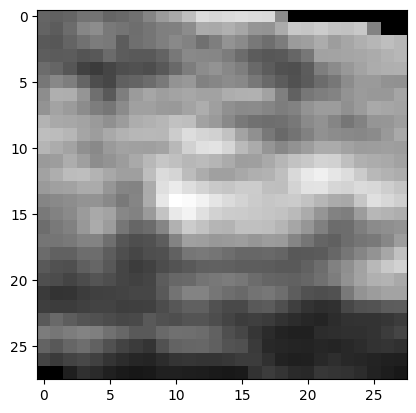

In [ ]:
print(f'Following is image from class {train_dataset[0][1][0]}') # Image with index 0 had label 0, so I used train_dataset[0][1][0].

plt.imshow(train_dataset[0][0].reshape((28, 28)), cmap='gray')
plt.show()

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


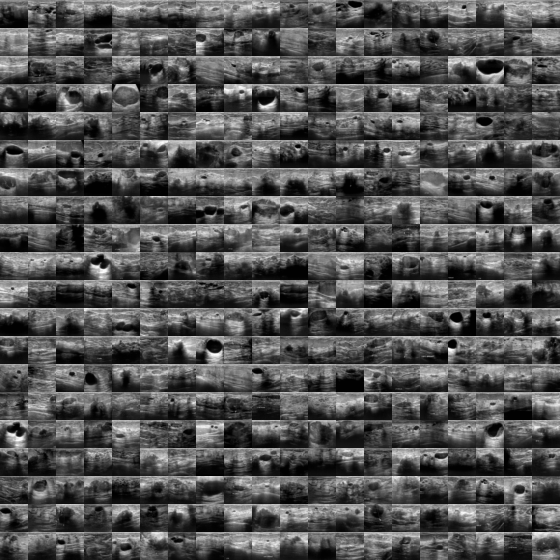

In [ ]:
# montage
train_dataset.montage(length=20)

## Define resnet18 model with transfer learning

In [ ]:
# Define the ResNet model
resnet = resnet18(pretrained=True)
resnet.conv1 = nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.5MB/s]


In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=lr)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Train model

In [ ]:
# Training loop
train_accuracy = []
val_accuracy = []
test_accuracy = []
total_loss = []

for epoch in range(NUM_EPOCHS):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.view(-1).to(device)  # Flatten the labels

        optimizer.zero_grad()

        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    total_loss.append(running_loss/len(train_loader))
    train_accuracy.append(100 * correct / total)

    # Calculate validation accuracy
    resnet.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.view(-1).to(device)

            outputs = resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy.append(100 * correct / total)

    # Calculate test accuracy
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.view(-1).to(device)

            outputs = resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {total_loss[-1]} - Train Accuracy: {train_accuracy[-1]:.2f}% - Val Accuracy: {val_accuracy[-1]:.2f}% - Test Accuracy: {test_accuracy[-1]:.2f}%")

100%|██████████| 69/69 [00:36<00:00,  1.88it/s]


Epoch 1/50 - Loss: 0.7919402260711228 - Train Accuracy: 60.44% - Val Accuracy: 70.51% - Test Accuracy: 73.72%


100%|██████████| 69/69 [00:18<00:00,  3.82it/s]


Epoch 2/50 - Loss: 0.6394985290109247 - Train Accuracy: 71.25% - Val Accuracy: 76.92% - Test Accuracy: 73.72%


100%|██████████| 69/69 [00:18<00:00,  3.79it/s]


Epoch 3/50 - Loss: 0.6261144660521245 - Train Accuracy: 70.51% - Val Accuracy: 66.67% - Test Accuracy: 71.15%


100%|██████████| 69/69 [00:17<00:00,  3.95it/s]


Epoch 4/50 - Loss: 0.6366187273592189 - Train Accuracy: 71.43% - Val Accuracy: 71.79% - Test Accuracy: 75.00%


100%|██████████| 69/69 [00:18<00:00,  3.78it/s]


Epoch 5/50 - Loss: 0.5991339607947115 - Train Accuracy: 72.16% - Val Accuracy: 69.23% - Test Accuracy: 78.21%


100%|██████████| 69/69 [00:18<00:00,  3.76it/s]


Epoch 6/50 - Loss: 0.593838938984318 - Train Accuracy: 73.08% - Val Accuracy: 78.21% - Test Accuracy: 76.28%


100%|██████████| 69/69 [00:19<00:00,  3.57it/s]


Epoch 7/50 - Loss: 0.569472331283749 - Train Accuracy: 72.89% - Val Accuracy: 66.67% - Test Accuracy: 77.56%


100%|██████████| 69/69 [00:19<00:00,  3.59it/s]


Epoch 8/50 - Loss: 0.5854832236317621 - Train Accuracy: 71.25% - Val Accuracy: 75.64% - Test Accuracy: 76.92%


100%|██████████| 69/69 [00:21<00:00,  3.24it/s]


Epoch 9/50 - Loss: 0.5790676100962404 - Train Accuracy: 72.34% - Val Accuracy: 75.64% - Test Accuracy: 78.21%


100%|██████████| 69/69 [00:38<00:00,  1.78it/s]


Epoch 10/50 - Loss: 0.5429850615884947 - Train Accuracy: 73.44% - Val Accuracy: 76.92% - Test Accuracy: 75.00%


100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 11/50 - Loss: 0.5329486123029736 - Train Accuracy: 76.01% - Val Accuracy: 82.05% - Test Accuracy: 77.56%


100%|██████████| 69/69 [00:17<00:00,  3.89it/s]


Epoch 12/50 - Loss: 0.5476967528246451 - Train Accuracy: 75.82% - Val Accuracy: 76.92% - Test Accuracy: 75.00%


100%|██████████| 69/69 [00:18<00:00,  3.80it/s]


Epoch 13/50 - Loss: 0.5871351447658263 - Train Accuracy: 71.61% - Val Accuracy: 75.64% - Test Accuracy: 75.64%


100%|██████████| 69/69 [00:18<00:00,  3.77it/s]


Epoch 14/50 - Loss: 0.5730156643667083 - Train Accuracy: 74.36% - Val Accuracy: 82.05% - Test Accuracy: 75.64%


100%|██████████| 69/69 [00:17<00:00,  3.84it/s]


Epoch 15/50 - Loss: 0.5424019379028375 - Train Accuracy: 74.18% - Val Accuracy: 82.05% - Test Accuracy: 77.56%


100%|██████████| 69/69 [00:17<00:00,  3.85it/s]


Epoch 16/50 - Loss: 0.5689091656519019 - Train Accuracy: 71.98% - Val Accuracy: 75.64% - Test Accuracy: 71.79%


100%|██████████| 69/69 [00:17<00:00,  3.91it/s]


Epoch 17/50 - Loss: 0.5413249160932458 - Train Accuracy: 73.99% - Val Accuracy: 82.05% - Test Accuracy: 78.21%


100%|██████████| 69/69 [00:18<00:00,  3.83it/s]


Epoch 18/50 - Loss: 0.5283646596514661 - Train Accuracy: 74.18% - Val Accuracy: 82.05% - Test Accuracy: 76.28%


100%|██████████| 69/69 [00:17<00:00,  3.91it/s]


Epoch 19/50 - Loss: 0.5112184044243633 - Train Accuracy: 76.74% - Val Accuracy: 82.05% - Test Accuracy: 76.28%


100%|██████████| 69/69 [00:18<00:00,  3.64it/s]


Epoch 20/50 - Loss: 0.568078059649122 - Train Accuracy: 73.44% - Val Accuracy: 78.21% - Test Accuracy: 75.00%


100%|██████████| 69/69 [00:17<00:00,  3.92it/s]


Epoch 21/50 - Loss: 0.546311989210654 - Train Accuracy: 74.91% - Val Accuracy: 76.92% - Test Accuracy: 75.00%


100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 22/50 - Loss: 0.5330084568780401 - Train Accuracy: 77.11% - Val Accuracy: 83.33% - Test Accuracy: 77.56%


100%|██████████| 69/69 [00:18<00:00,  3.81it/s]


Epoch 23/50 - Loss: 0.5421019978281381 - Train Accuracy: 74.18% - Val Accuracy: 75.64% - Test Accuracy: 81.41%


100%|██████████| 69/69 [00:18<00:00,  3.66it/s]


Epoch 24/50 - Loss: 0.5318047179692034 - Train Accuracy: 75.27% - Val Accuracy: 84.62% - Test Accuracy: 80.13%


100%|██████████| 69/69 [00:21<00:00,  3.24it/s]


Epoch 25/50 - Loss: 0.5331595062777617 - Train Accuracy: 75.09% - Val Accuracy: 85.90% - Test Accuracy: 77.56%


100%|██████████| 69/69 [00:17<00:00,  3.93it/s]


Epoch 26/50 - Loss: 0.5513896089101183 - Train Accuracy: 74.54% - Val Accuracy: 84.62% - Test Accuracy: 77.56%


100%|██████████| 69/69 [00:18<00:00,  3.71it/s]


Epoch 27/50 - Loss: 0.5198362530141637 - Train Accuracy: 76.37% - Val Accuracy: 80.77% - Test Accuracy: 78.21%


100%|██████████| 69/69 [00:17<00:00,  3.90it/s]


Epoch 28/50 - Loss: 0.5235113842763762 - Train Accuracy: 76.74% - Val Accuracy: 80.77% - Test Accuracy: 80.13%


100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 29/50 - Loss: 0.5441404844539753 - Train Accuracy: 75.27% - Val Accuracy: 82.05% - Test Accuracy: 76.92%


100%|██████████| 69/69 [00:17<00:00,  3.84it/s]


Epoch 30/50 - Loss: 0.5151175213032875 - Train Accuracy: 74.54% - Val Accuracy: 83.33% - Test Accuracy: 80.77%


100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 31/50 - Loss: 0.5266637266546056 - Train Accuracy: 78.21% - Val Accuracy: 80.77% - Test Accuracy: 77.56%


100%|██████████| 69/69 [00:17<00:00,  3.87it/s]


Epoch 32/50 - Loss: 0.5305258353119311 - Train Accuracy: 76.01% - Val Accuracy: 85.90% - Test Accuracy: 80.13%


100%|██████████| 69/69 [00:18<00:00,  3.73it/s]


Epoch 33/50 - Loss: 0.48175947346549103 - Train Accuracy: 79.49% - Val Accuracy: 84.62% - Test Accuracy: 78.85%


100%|██████████| 69/69 [00:18<00:00,  3.78it/s]


Epoch 34/50 - Loss: 0.49956876860148663 - Train Accuracy: 77.29% - Val Accuracy: 85.90% - Test Accuracy: 76.92%


100%|██████████| 69/69 [00:18<00:00,  3.70it/s]


Epoch 35/50 - Loss: 0.5230045016261115 - Train Accuracy: 73.26% - Val Accuracy: 78.21% - Test Accuracy: 79.49%


100%|██████████| 69/69 [00:18<00:00,  3.81it/s]


Epoch 36/50 - Loss: 0.5206938182962113 - Train Accuracy: 74.73% - Val Accuracy: 82.05% - Test Accuracy: 81.41%


100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 37/50 - Loss: 0.49909082011900086 - Train Accuracy: 77.66% - Val Accuracy: 76.92% - Test Accuracy: 77.56%


100%|██████████| 69/69 [00:17<00:00,  3.85it/s]


Epoch 38/50 - Loss: 0.4768646907979164 - Train Accuracy: 76.92% - Val Accuracy: 83.33% - Test Accuracy: 81.41%


100%|██████████| 69/69 [00:18<00:00,  3.66it/s]


Epoch 39/50 - Loss: 0.5027812324140383 - Train Accuracy: 75.82% - Val Accuracy: 89.74% - Test Accuracy: 80.77%


100%|██████████| 69/69 [00:17<00:00,  3.84it/s]


Epoch 40/50 - Loss: 0.4921934978253599 - Train Accuracy: 78.02% - Val Accuracy: 83.33% - Test Accuracy: 80.77%


100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 41/50 - Loss: 0.5237252854782602 - Train Accuracy: 76.19% - Val Accuracy: 83.33% - Test Accuracy: 77.56%


100%|██████████| 69/69 [00:18<00:00,  3.77it/s]


Epoch 42/50 - Loss: 0.48675526311432105 - Train Accuracy: 76.92% - Val Accuracy: 87.18% - Test Accuracy: 80.77%


100%|██████████| 69/69 [00:19<00:00,  3.59it/s]


Epoch 43/50 - Loss: 0.5084197041781052 - Train Accuracy: 75.82% - Val Accuracy: 84.62% - Test Accuracy: 77.56%


100%|██████████| 69/69 [00:18<00:00,  3.81it/s]


Epoch 44/50 - Loss: 0.4997366826603378 - Train Accuracy: 76.01% - Val Accuracy: 84.62% - Test Accuracy: 78.21%


100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 45/50 - Loss: 0.4947712857654129 - Train Accuracy: 76.56% - Val Accuracy: 80.77% - Test Accuracy: 78.21%


100%|██████████| 69/69 [00:18<00:00,  3.83it/s]


Epoch 46/50 - Loss: 0.4799946641576463 - Train Accuracy: 78.39% - Val Accuracy: 85.90% - Test Accuracy: 80.13%


100%|██████████| 69/69 [00:19<00:00,  3.61it/s]


Epoch 47/50 - Loss: 0.531813357187354 - Train Accuracy: 77.11% - Val Accuracy: 76.92% - Test Accuracy: 78.85%


100%|██████████| 69/69 [00:17<00:00,  3.84it/s]


Epoch 48/50 - Loss: 0.48716110574162524 - Train Accuracy: 78.57% - Val Accuracy: 84.62% - Test Accuracy: 80.77%


100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 49/50 - Loss: 0.470914916931719 - Train Accuracy: 77.84% - Val Accuracy: 82.05% - Test Accuracy: 81.41%


100%|██████████| 69/69 [00:17<00:00,  3.85it/s]


Epoch 50/50 - Loss: 0.49603334673936816 - Train Accuracy: 78.21% - Val Accuracy: 79.49% - Test Accuracy: 79.49%


### Plot loss and train, val and test accuracy

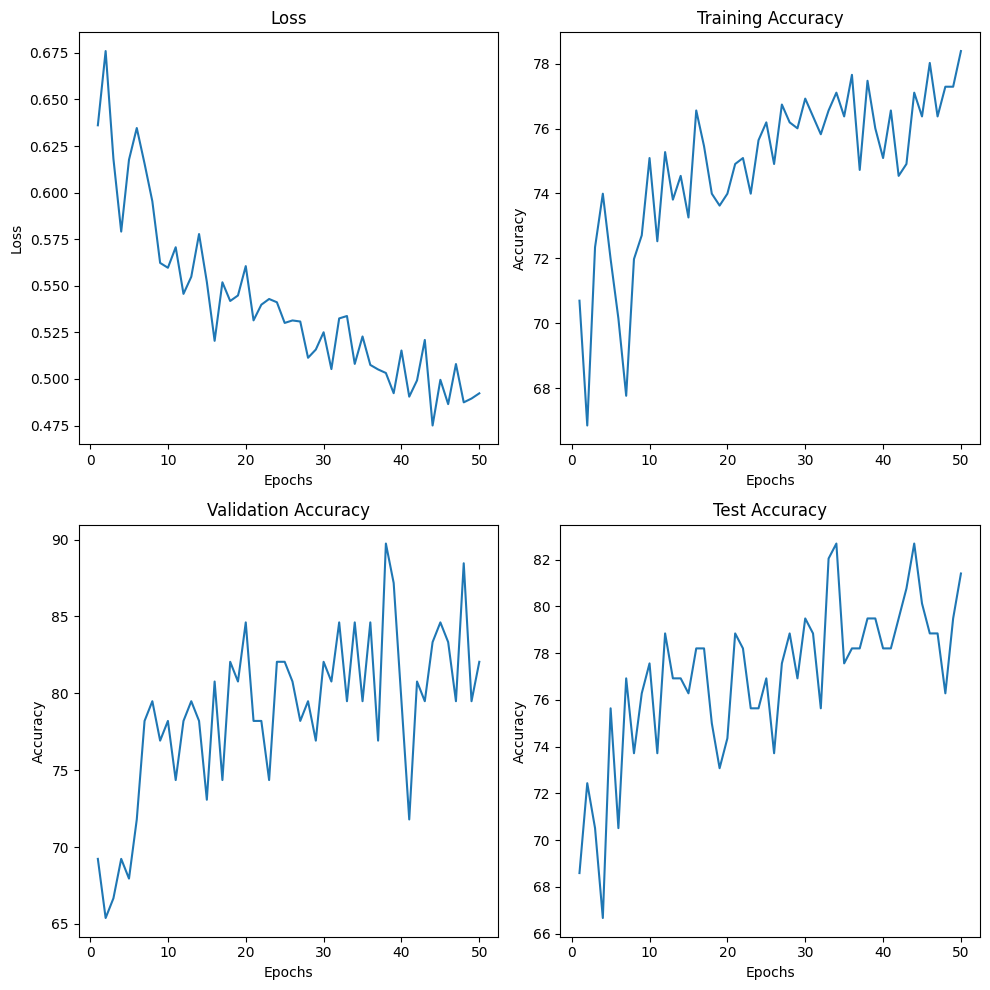

In [ ]:
# Plotting Loss
epochs = range(1, NUM_EPOCHS+1)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot Loss
axs[0, 0].plot(epochs, total_loss)
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('Loss')

# Plot Train Accuracy
axs[0, 1].plot(epochs, train_accuracy)
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_title('Training Accuracy')

# Plot Validation Accuracy
axs[1, 0].plot(epochs, val_accuracy)
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('Validation Accuracy')

# Plot Test Accuracy
axs[1, 1].plot(epochs, test_accuracy)
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

### Confusion matrix

In [ ]:
# Calculate test accuracy and confusion matrix
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.view(-1).to(device)

        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

test_accuracy.append(100 * correct / total)

# Calculate confusion matrix
confusion_mat = confusion_matrix(true_labels, predictions)

print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {total_loss[-1]} - Train Accuracy: {train_accuracy[-1]:.2f}% - Val Accuracy: {val_accuracy[-1]:.2f}% - Test Accuracy: {test_accuracy[-1]:.2f}%")
print("Confusion Matrix:")
print(confusion_mat)

Epoch 50/50 - Loss: 0.49230653501075244 - Train Accuracy: 78.39% - Val Accuracy: 82.05% - Test Accuracy: 83.33%
Confusion Matrix:
[[ 21  21]
 [  5 109]]


# Conditional DCGAN

## First Implementation with 600 epochs

In [ ]:
import torchvision.transforms as transforms

### Define Generator and Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

### Load and preprocess data

In [ ]:
# BreastMNIST
data_flag = 'breastmnist'
info = INFO[data_flag]
task = info['task']
DataClass = getattr(medmnist, info['python_class'])
NUM_CLASSES = len(info['label'])

# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = info['n_channels']
NOISE_DIM = 100
NUM_EPOCHS = 600
FEATURES_DISC = 64
FEATURES_GEN = 64

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

# Load the data
train_dataset = DataClass(split='train', transform=transforms, download=True)
dataloader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = DataClass(split='val', transform=transforms, download=True)
val_dataloader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = DataClass(split='test', transform=transforms, download=True)
test_dataloader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [ ]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

d_loss_list = []
g_loss_list = []

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:

            # Compute the accuracy on the validation set
            with torch.no_grad():
                num_correct_real = 0
                num_correct_fake = 0
                num_samples_real = 0
                num_samples_fake = 0
                for real, _ in val_dataloader:
                    real = real.to(device)
                    outputs_real = disc(real).view(-1)
                    predictions_real = (outputs_real > 0.5).float()
                    num_correct_real += (predictions_real == 1).sum().item()
                    num_samples_real += predictions_real.numel()

                    noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
                    fake = gen(noise)
                    outputs_fake = disc(fake.detach()).view(-1)
                    predictions_fake = (outputs_fake <= 0.5).float()
                    num_correct_fake += (predictions_fake == 1).sum().item()
                    num_samples_fake += predictions_fake.numel()

                acc_real = 100.0 * num_correct_real / num_samples_real
                acc_fake = 100.0 * num_correct_fake / num_samples_fake
                acc_total = 0.5 * (acc_real + acc_fake)
                print(f"Accuracy on validation set: {acc_total:.2f}%")

            # Compute the accuracy on the train set
            with torch.no_grad():
                num_correct_real = 0
                num_correct_fake = 0
                num_samples_real = 0
                num_samples_fake = 0
                for real, _ in dataloader:
                    real = real.to(device)
                    outputs_real = disc(real).view(-1)
                    predictions_real = (outputs_real > 0.5).float()
                    num_correct_real += (predictions_real == 1).sum().item()
                    num_samples_real += predictions_real.numel()

                    noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
                    fake = gen(noise)
                    outputs_fake = disc(fake.detach()).view(-1)
                    predictions_fake = (outputs_fake <= 0.5).float()
                    num_correct_fake += (predictions_fake == 1).sum().item()
                    num_samples_fake += predictions_fake.numel()

                acc_real = 100.0 * num_correct_real / num_samples_real
                acc_fake = 100.0 * num_correct_fake / num_samples_fake
                acc_total = 0.5 * (acc_real + acc_fake)
                print(f"Accuracy on train set: {acc_total:.2f}%")

            # Compute the accuracy on the test set
            with torch.no_grad():
                num_correct_real = 0
                num_correct_fake = 0
                num_samples_real = 0
                num_samples_fake = 0
                for real, _ in test_dataloader:
                    real = real.to(device)
                    outputs_real = disc(real).view(-1)
                    predictions_real = (outputs_real > 0.5).float()
                    num_correct_real += (predictions_real == 1).sum().item()
                    num_samples_real += predictions_real.numel()

                    noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
                    fake = gen(noise)
                    outputs_fake = disc(fake.detach()).view(-1)
                    predictions_fake = (outputs_fake <= 0.5).float()
                    num_correct_fake += (predictions_fake == 1).sum().item()
                    num_samples_fake += predictions_fake.numel()

                acc_real = 100.0 * num_correct_real / num_samples_real
                acc_fake = 100.0 * num_correct_fake / num_samples_fake
                acc_total = 0.5 * (acc_real + acc_fake)
                print(f"Accuracy on test set: {acc_total:.2f}%")

            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )
            d_loss_list.append(loss_disc)
            g_loss_list.append(loss_gen)

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

Accuracy on validation set: 93.50%
Accuracy on train set: 94.64%
Accuracy on test set: 91.62%
Epoch [0/600] Batch 0/5                   Loss D: 0.6974, loss G: 0.6969
Accuracy on validation set: 42.95%
Accuracy on train set: 43.22%
Accuracy on test set: 41.67%
Epoch [1/600] Batch 0/5                   Loss D: 0.6765, loss G: 0.6348
Accuracy on validation set: 95.51%
Accuracy on train set: 96.61%
Accuracy on test set: 95.51%
Epoch [2/600] Batch 0/5                   Loss D: 0.2548, loss G: 2.3530
Accuracy on validation set: 87.18%
Accuracy on train set: 81.59%
Accuracy on test set: 81.41%
Epoch [3/600] Batch 0/5                   Loss D: 0.6214, loss G: 1.5503
Accuracy on validation set: 95.51%
Accuracy on train set: 95.70%
Accuracy on test set: 94.23%
Epoch [4/600] Batch 0/5                   Loss D: 0.1579, loss G: 2.3955
Accuracy on validation set: 89.10%
Accuracy on train set: 83.88%
Accuracy on test set: 83.65%
Epoch [5/600] Batch 0/5                   Loss D: 0.5621, loss G: 1.878

### Plot Discriminator and Generator Loss

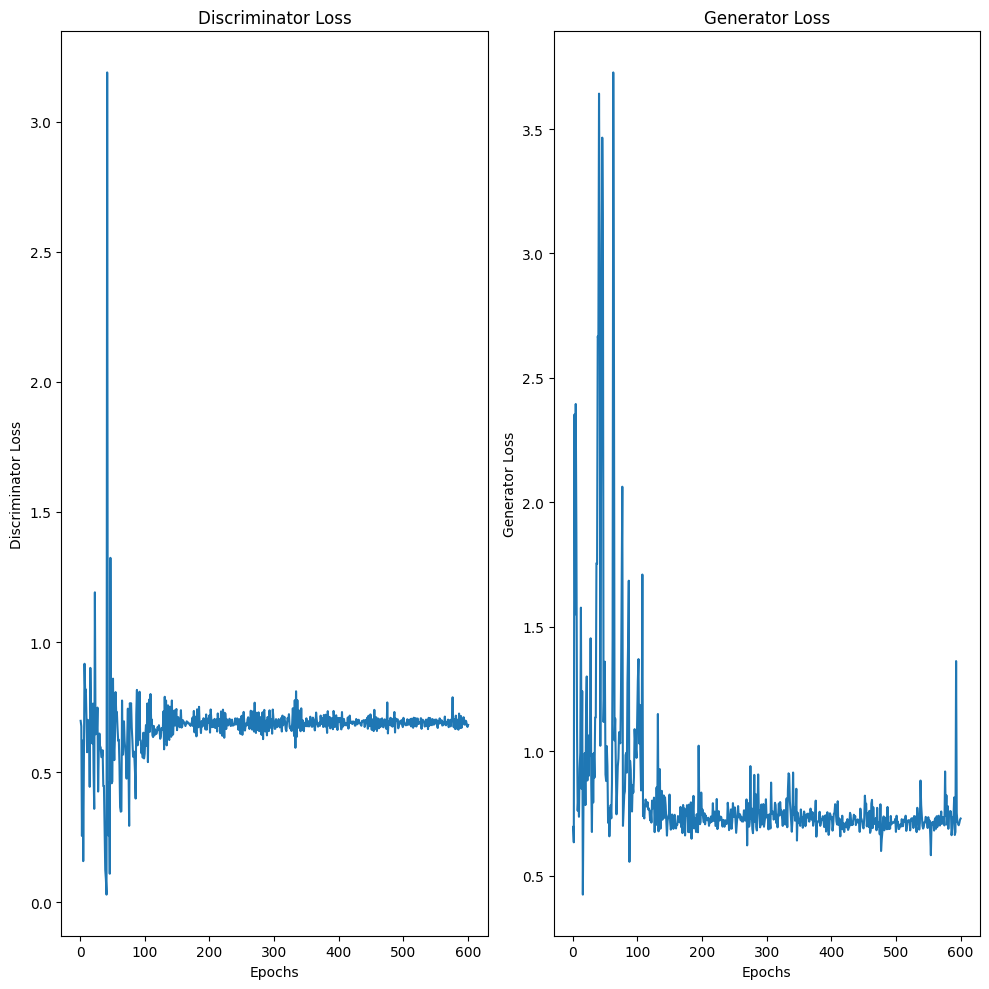

In [ ]:
# Move the tensors to CPU memory
d_loss_list_cpu = [loss.item() for loss in d_loss_list]
g_loss_list_cpu = [loss.item() for loss in g_loss_list]

# Plotting Loss
epochs = range(1, NUM_EPOCHS+1)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# Plot Discriminator Loss
axs[0].plot(epochs, d_loss_list_cpu)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Discriminator Loss')
axs[0].set_title('Discriminator Loss')

# Plot Generator Loss
axs[1].plot(epochs, g_loss_list_cpu)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Generator Loss')
axs[1].set_title('Generator Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Set the number of samples per class
num_samples = 2000

# Loop through the dataset and generate samples for each class
for class_idx in range(NUM_CLASSES):
    # Create a directory for the class
    class_dir = f"class_{class_idx}"
    os.makedirs(class_dir, exist_ok=True)

    # Generate samples for the class
    for i in range(num_samples):
        # Generate a noise vector
        noise = torch.randn(1, NOISE_DIM, 1, 1).to(device)

        # Generate a sample using the generator
        with torch.no_grad():
            sample = gen(noise).cpu()

        # Save the sample as a JPEG image
        filename = os.path.join(class_dir, f"sample_{i}.jpg")
        vutils.save_image(sample, filename, normalize=True)

class = 0


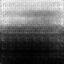

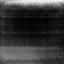

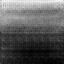

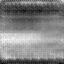

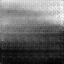

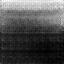

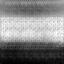

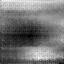

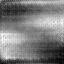

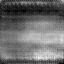

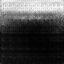

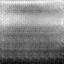

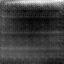

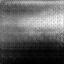

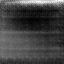

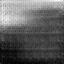

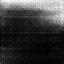

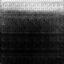

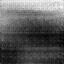

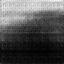

class = 1


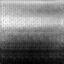

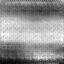

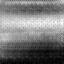

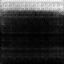

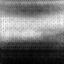

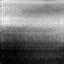

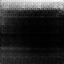

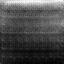

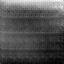

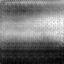

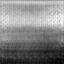

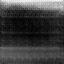

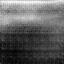

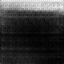

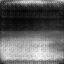

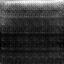

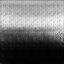

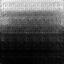

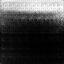

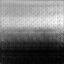

In [ ]:
from PIL import Image

# Loop through the classes and show 20 images for each class
for class_idx in range(NUM_CLASSES):
    print(f"class = {class_idx}")
    class_dir = f"class_{class_idx}"

    # Loop through the images in the class directory and show the first 20
    for i in range(20):
        filename = os.path.join(class_dir, f"sample_{i}.jpg")
        image = Image.open(filename)
        image.show()

## Second Implementation with 1000 epochs

In [ ]:
import torchvision.transforms as transforms

### Load and preprocess data

In [ ]:
# BreastMNIST
data_flag = 'breastmnist'
info = INFO[data_flag]
task = info['task']
DataClass = getattr(medmnist, info['python_class'])
NUM_CLASSES = len(info['label'])

# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = info['n_channels']
NOISE_DIM = 100
NUM_EPOCHS = 1000
FEATURES_DISC = 64
FEATURES_GEN = 64

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

# Load the data
train_dataset = DataClass(split='train', transform=transforms, download=True)
dataloader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = DataClass(split='val', transform=transforms, download=True)
val_dataloader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = DataClass(split='test', transform=transforms, download=True)
test_dataloader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 559580/559580 [00:01<00:00, 305301.22it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


### Define Generator and Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

d_loss_list = []
g_loss_list = []

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:

            # Compute the accuracy on the validation set
            with torch.no_grad():
                num_correct_real = 0
                num_correct_fake = 0
                num_samples_real = 0
                num_samples_fake = 0
                for real, _ in val_dataloader:
                    real = real.to(device)
                    outputs_real = disc(real).view(-1)
                    predictions_real = (outputs_real > 0.5).float()
                    num_correct_real += (predictions_real == 1).sum().item()
                    num_samples_real += predictions_real.numel()

                    noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
                    fake = gen(noise)
                    outputs_fake = disc(fake.detach()).view(-1)
                    predictions_fake = (outputs_fake <= 0.5).float()
                    num_correct_fake += (predictions_fake == 1).sum().item()
                    num_samples_fake += predictions_fake.numel()

                acc_real = 100.0 * num_correct_real / num_samples_real
                acc_fake = 100.0 * num_correct_fake / num_samples_fake
                acc_total = 0.5 * (acc_real + acc_fake)
                print(f"Accuracy on validation set: {acc_total:.2f}%")

            # Compute the accuracy on the train set
            with torch.no_grad():
                num_correct_real = 0
                num_correct_fake = 0
                num_samples_real = 0
                num_samples_fake = 0
                for real, _ in dataloader:
                    real = real.to(device)
                    outputs_real = disc(real).view(-1)
                    predictions_real = (outputs_real > 0.5).float()
                    num_correct_real += (predictions_real == 1).sum().item()
                    num_samples_real += predictions_real.numel()

                    noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
                    fake = gen(noise)
                    outputs_fake = disc(fake.detach()).view(-1)
                    predictions_fake = (outputs_fake <= 0.5).float()
                    num_correct_fake += (predictions_fake == 1).sum().item()
                    num_samples_fake += predictions_fake.numel()

                acc_real = 100.0 * num_correct_real / num_samples_real
                acc_fake = 100.0 * num_correct_fake / num_samples_fake
                acc_total = 0.5 * (acc_real + acc_fake)
                print(f"Accuracy on train set: {acc_total:.2f}%")

            # Compute the accuracy on the test set
            with torch.no_grad():
                num_correct_real = 0
                num_correct_fake = 0
                num_samples_real = 0
                num_samples_fake = 0
                for real, _ in test_dataloader:
                    real = real.to(device)
                    outputs_real = disc(real).view(-1)
                    predictions_real = (outputs_real > 0.5).float()
                    num_correct_real += (predictions_real == 1).sum().item()
                    num_samples_real += predictions_real.numel()

                    noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
                    fake = gen(noise)
                    outputs_fake = disc(fake.detach()).view(-1)
                    predictions_fake = (outputs_fake <= 0.5).float()
                    num_correct_fake += (predictions_fake == 1).sum().item()
                    num_samples_fake += predictions_fake.numel()

                acc_real = 100.0 * num_correct_real / num_samples_real
                acc_fake = 100.0 * num_correct_fake / num_samples_fake
                acc_total = 0.5 * (acc_real + acc_fake)
                print(f"Accuracy on test set: {acc_total:.2f}%")

            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )
            d_loss_list.append(loss_disc)
            g_loss_list.append(loss_gen)

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

Accuracy on validation set: 50.00%
Accuracy on train set: 50.00%
Accuracy on test set: 50.00%
Epoch [0/1000] Batch 0/5                   Loss D: 0.6927, loss G: 0.6387
Accuracy on validation set: 52.56%
Accuracy on train set: 51.74%
Accuracy on test set: 52.56%
Epoch [1/1000] Batch 0/5                   Loss D: 0.8013, loss G: 1.1884
Accuracy on validation set: 98.08%
Accuracy on train set: 98.17%
Accuracy on test set: 98.08%
Epoch [2/1000] Batch 0/5                   Loss D: 0.4245, loss G: 1.4718
Accuracy on validation set: 32.69%
Accuracy on train set: 25.92%
Accuracy on test set: 26.60%
Epoch [3/1000] Batch 0/5                   Loss D: 0.7918, loss G: 1.7429
Accuracy on validation set: 98.08%
Accuracy on train set: 97.62%
Accuracy on test set: 96.47%
Epoch [4/1000] Batch 0/5                   Loss D: 0.2144, loss G: 2.1985
Accuracy on validation set: 89.74%
Accuracy on train set: 88.83%
Accuracy on test set: 86.86%
Epoch [5/1000] Batch 0/5                   Loss D: 0.6825, loss G:

### Plot Discriminator and Generator Loss

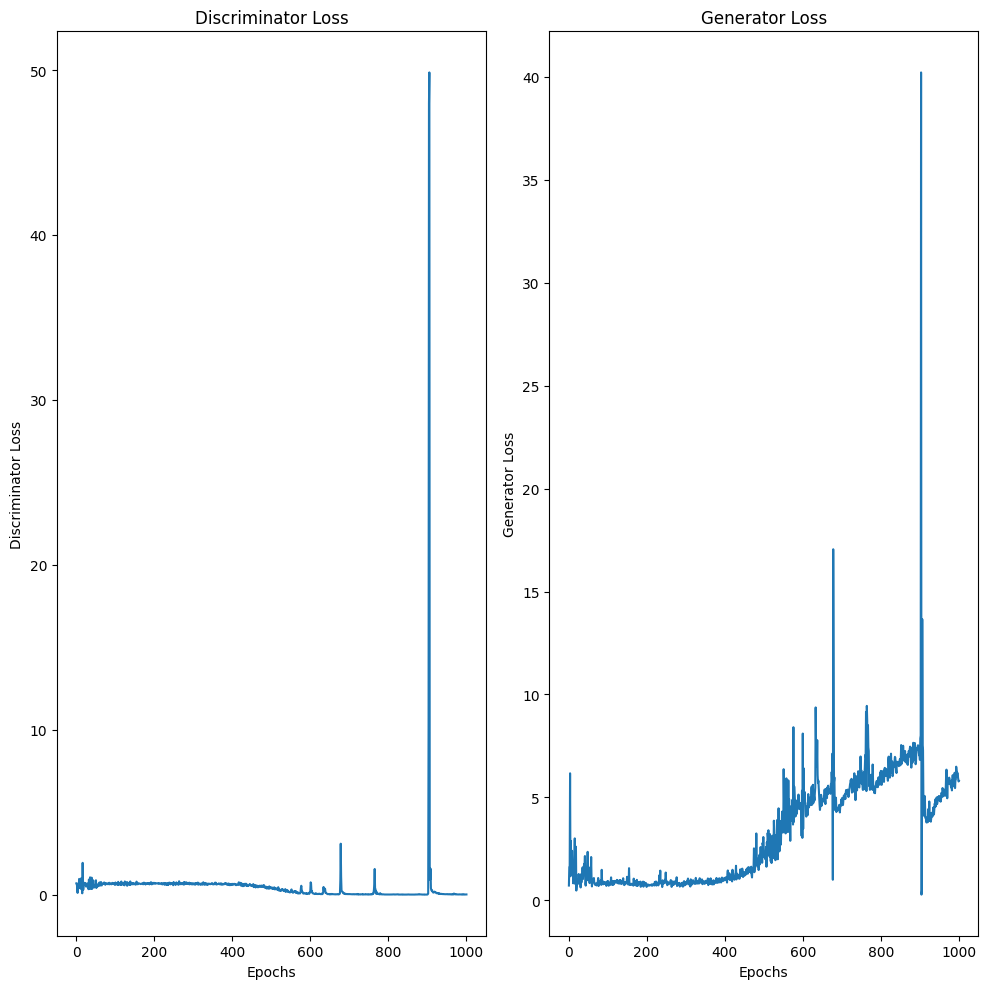

In [ ]:
# Move the tensors to CPU memory
d_loss_list_cpu = [loss.item() for loss in d_loss_list]
g_loss_list_cpu = [loss.item() for loss in g_loss_list]

# Plotting Loss
epochs = range(1, NUM_EPOCHS+1)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# Plot Discriminator Loss
axs[0].plot(epochs, d_loss_list_cpu)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Discriminator Loss')
axs[0].set_title('Discriminator Loss')

# Plot Generator Loss
axs[1].plot(epochs, g_loss_list_cpu)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Generator Loss')
axs[1].set_title('Generator Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Set the number of samples per class
num_samples = 2000

# Loop through the dataset and generate samples for each class
for class_idx in range(NUM_CLASSES):
    # Create a directory for the class
    class_dir = f"class_{class_idx}_second"
    os.makedirs(class_dir, exist_ok=True)

    # Generate samples for the class
    for i in range(num_samples):
        # Generate a noise vector
        noise = torch.randn(1, NOISE_DIM, 1, 1).to(device)

        # Generate a sample using the generator
        with torch.no_grad():
            sample = gen(noise).cpu()

        # Save the sample as a JPEG image
        filename = os.path.join(class_dir, f"sample_{i}.jpg")
        vutils.save_image(sample, filename, normalize=True)

class = 0


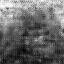

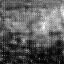

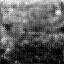

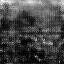

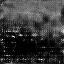

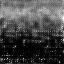

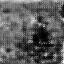

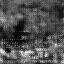

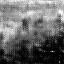

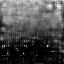

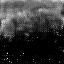

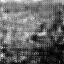

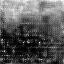

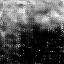

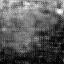

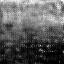

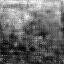

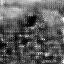

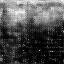

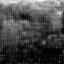

class = 1


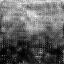

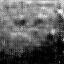

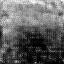

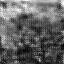

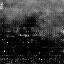

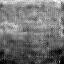

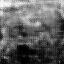

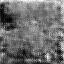

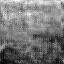

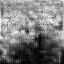

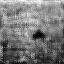

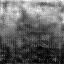

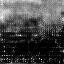

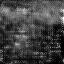

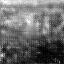

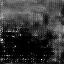

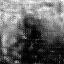

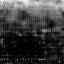

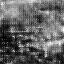

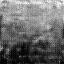

In [ ]:
from PIL import Image

# Loop through the classes and show 20 images for each class
for class_idx in range(NUM_CLASSES):
    print(f"class = {class_idx}")
    class_dir = f"class_{class_idx}_second"

    # Loop through the images in the class directory and show the first 20
    for i in range(20):
        filename = os.path.join(class_dir, f"sample_{i}.jpg")
        image = Image.open(filename)
        image.show()

# Classification using the data generated by the generator

In [230]:
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
import medmnist
from medmnist import INFO
import medmnist_loader
from medmnist_loader import get_loader

import torch
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras import layers
import cv2


# from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio

In [231]:
def transform_to_numpy(dataset):

    X, y = [], []
    for img, label in dataset:
        img = np.array(img)
        X.append(img)
        y.append(label)

    y = np.array(y).reshape((-1,))
    # y = keras.utils.to_categorical(y)
    X = np.array(X).reshape((-1, 1, 28, 28))
    return X, y

In [232]:
info = INFO['breastmnist']
DataClass = getattr(medmnist_loader, info['python_class'])

n_channels = info['n_channels']
n_classes = len(info['label'])
task = info['task']

NUM_EPOCHS = 50
BATCH_SIZE = 8
lr = 0.0001

X_train, y_train = transform_to_numpy(DataClass(split='train', download=True))
X_val, y_val = transform_to_numpy(DataClass(split='val', download=True))
X_test, y_test = transform_to_numpy(DataClass(split='test', download=True))

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [233]:
class_labels = y_train
labels_count = {}
unique_labels, counts = np.unique(class_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    labels_count[label] = count
    print(f"Class {label}: {count} samples")

Class 0: 147 samples
Class 1: 399 samples


In [234]:
import random
from PIL import Image

# Step 1: Load images from the "class_0_second" folder
class_0_path = 'class_0_second'  # Replace with the actual path to the folder
class_0_data = []
for filename in os.listdir(class_0_path):
    img = np.array(Image.open(os.path.join(class_0_path, filename)))
    img = np.resize(img, (1, 28, 28))
    class_0_data.append(img)

# Step 2: Shuffle the new dataset
random.shuffle(class_0_data)

# Step 3: Select the required number of samples
num_samples = len(class_0_data)
selected_samples = class_0_data[:252]

# Step 4: Append the selected samples to the existing dataset
X_train_new = np.array(selected_samples).reshape((-1, 1, 28, 28))
y_train_new = np.array([0.] * 252)

X_train = np.concatenate((X_train, X_train_new), axis=0)
y_train = np.concatenate((y_train, y_train_new), axis=0)

In [235]:
X_train.shape, y_train.shape

((798, 1, 28, 28), (798,))

In [236]:
class_labels = y_train

labels_count = {}
unique_labels, counts = np.unique(class_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    labels_count[label] = count
    print(f"Class {label}: {count} samples")

Class 0.0: 399 samples
Class 1.0: 399 samples


In [237]:
# Convert NumPy arrays to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Create new TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create new DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2*BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=2*BATCH_SIZE)

In [238]:
# Define the ResNet model
resnet = resnet18(pretrained=True)
resnet.conv1 = nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [239]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=lr)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [240]:
# Training loop
train_accuracy = []
val_accuracy = []
test_accuracy = []
total_loss = []

for epoch in range(NUM_EPOCHS):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.view(-1).to(device)  # Flatten the labels
        optimizer.zero_grad()

        outputs = resnet(images)
        loss = criterion(outputs, labels.long())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    total_loss.append(running_loss/len(train_loader))
    train_accuracy.append(100 * correct / total)

    # Calculate validation accuracy
    resnet.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.view(-1).to(device)

            outputs = resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy.append(100 * correct / total)

    # Calculate test accuracy
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.view(-1).to(device)

            outputs = resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {total_loss[-1]} - Train Accuracy: {train_accuracy[-1]:.2f}% - Val Accuracy: {val_accuracy[-1]:.2f}% - Test Accuracy: {test_accuracy[-1]:.2f}%")

100%|██████████| 100/100 [00:01<00:00, 74.24it/s]


Epoch 1/50 - Loss: 0.6278365048766136 - Train Accuracy: 68.80% - Val Accuracy: 70.51% - Test Accuracy: 67.95%


100%|██████████| 100/100 [00:02<00:00, 48.77it/s]


Epoch 2/50 - Loss: 0.5240594565868377 - Train Accuracy: 77.57% - Val Accuracy: 79.49% - Test Accuracy: 77.56%


100%|██████████| 100/100 [00:02<00:00, 38.28it/s]


Epoch 3/50 - Loss: 0.4957956526428461 - Train Accuracy: 77.44% - Val Accuracy: 74.36% - Test Accuracy: 80.77%


100%|██████████| 100/100 [00:01<00:00, 70.69it/s]


Epoch 4/50 - Loss: 0.444148868098855 - Train Accuracy: 79.95% - Val Accuracy: 76.92% - Test Accuracy: 75.64%


100%|██████████| 100/100 [00:01<00:00, 79.16it/s]


Epoch 5/50 - Loss: 0.4388829679787159 - Train Accuracy: 79.07% - Val Accuracy: 75.64% - Test Accuracy: 75.64%


100%|██████████| 100/100 [00:01<00:00, 64.20it/s]


Epoch 6/50 - Loss: 0.38449622243642806 - Train Accuracy: 85.84% - Val Accuracy: 80.77% - Test Accuracy: 80.77%


100%|██████████| 100/100 [00:01<00:00, 70.52it/s]


Epoch 7/50 - Loss: 0.3958996760845184 - Train Accuracy: 83.21% - Val Accuracy: 82.05% - Test Accuracy: 77.56%


100%|██████████| 100/100 [00:01<00:00, 79.35it/s]


Epoch 8/50 - Loss: 0.3373170968145132 - Train Accuracy: 86.84% - Val Accuracy: 78.21% - Test Accuracy: 74.36%


100%|██████████| 100/100 [00:01<00:00, 80.82it/s]


Epoch 9/50 - Loss: 0.3170989840105176 - Train Accuracy: 85.96% - Val Accuracy: 83.33% - Test Accuracy: 79.49%


100%|██████████| 100/100 [00:01<00:00, 78.43it/s]


Epoch 10/50 - Loss: 0.35741541845723984 - Train Accuracy: 85.71% - Val Accuracy: 79.49% - Test Accuracy: 83.33%


100%|██████████| 100/100 [00:01<00:00, 78.94it/s]


Epoch 11/50 - Loss: 0.29884302861988543 - Train Accuracy: 88.10% - Val Accuracy: 91.03% - Test Accuracy: 83.97%


100%|██████████| 100/100 [00:01<00:00, 79.23it/s]


Epoch 12/50 - Loss: 0.30268778540194036 - Train Accuracy: 88.85% - Val Accuracy: 80.77% - Test Accuracy: 84.62%


100%|██████████| 100/100 [00:01<00:00, 77.88it/s]


Epoch 13/50 - Loss: 0.2737431949749589 - Train Accuracy: 89.85% - Val Accuracy: 87.18% - Test Accuracy: 81.41%


100%|██████████| 100/100 [00:01<00:00, 79.65it/s]


Epoch 14/50 - Loss: 0.2772199533507228 - Train Accuracy: 88.85% - Val Accuracy: 75.64% - Test Accuracy: 80.13%


100%|██████████| 100/100 [00:01<00:00, 61.71it/s]


Epoch 15/50 - Loss: 0.20765743635594844 - Train Accuracy: 90.60% - Val Accuracy: 83.33% - Test Accuracy: 82.05%


100%|██████████| 100/100 [00:01<00:00, 70.91it/s]


Epoch 16/50 - Loss: 0.19926285956054926 - Train Accuracy: 92.61% - Val Accuracy: 75.64% - Test Accuracy: 81.41%


100%|██████████| 100/100 [00:01<00:00, 80.07it/s]


Epoch 17/50 - Loss: 0.21648288774304092 - Train Accuracy: 91.73% - Val Accuracy: 76.92% - Test Accuracy: 76.28%


100%|██████████| 100/100 [00:01<00:00, 79.01it/s]


Epoch 18/50 - Loss: 0.21424100533127785 - Train Accuracy: 93.11% - Val Accuracy: 79.49% - Test Accuracy: 75.64%


100%|██████████| 100/100 [00:01<00:00, 78.66it/s]


Epoch 19/50 - Loss: 0.250202563572675 - Train Accuracy: 90.23% - Val Accuracy: 84.62% - Test Accuracy: 83.33%


100%|██████████| 100/100 [00:01<00:00, 80.15it/s]


Epoch 20/50 - Loss: 0.2131047396361828 - Train Accuracy: 93.23% - Val Accuracy: 80.77% - Test Accuracy: 80.77%


100%|██████████| 100/100 [00:01<00:00, 80.21it/s]


Epoch 21/50 - Loss: 0.12004481432028115 - Train Accuracy: 95.61% - Val Accuracy: 82.05% - Test Accuracy: 81.41%


100%|██████████| 100/100 [00:01<00:00, 79.20it/s]


Epoch 22/50 - Loss: 0.16914916224312038 - Train Accuracy: 94.74% - Val Accuracy: 84.62% - Test Accuracy: 78.21%


100%|██████████| 100/100 [00:01<00:00, 76.63it/s]


Epoch 23/50 - Loss: 0.14016076941974462 - Train Accuracy: 94.86% - Val Accuracy: 87.18% - Test Accuracy: 82.05%


100%|██████████| 100/100 [00:01<00:00, 63.92it/s]


Epoch 24/50 - Loss: 0.12894790099933742 - Train Accuracy: 96.49% - Val Accuracy: 83.33% - Test Accuracy: 80.77%


100%|██████████| 100/100 [00:01<00:00, 73.79it/s]


Epoch 25/50 - Loss: 0.09352330023888498 - Train Accuracy: 97.49% - Val Accuracy: 85.90% - Test Accuracy: 82.69%


100%|██████████| 100/100 [00:01<00:00, 79.42it/s]


Epoch 26/50 - Loss: 0.1033089651260525 - Train Accuracy: 97.12% - Val Accuracy: 85.90% - Test Accuracy: 82.05%


100%|██████████| 100/100 [00:01<00:00, 80.02it/s]


Epoch 27/50 - Loss: 0.13362131615169345 - Train Accuracy: 95.86% - Val Accuracy: 84.62% - Test Accuracy: 81.41%


100%|██████████| 100/100 [00:01<00:00, 79.69it/s]


Epoch 28/50 - Loss: 0.15193562068976463 - Train Accuracy: 95.36% - Val Accuracy: 83.33% - Test Accuracy: 78.21%


100%|██████████| 100/100 [00:01<00:00, 80.16it/s]


Epoch 29/50 - Loss: 0.12338212584145367 - Train Accuracy: 96.37% - Val Accuracy: 79.49% - Test Accuracy: 81.41%


100%|██████████| 100/100 [00:01<00:00, 79.34it/s]


Epoch 30/50 - Loss: 0.07477871716255322 - Train Accuracy: 97.12% - Val Accuracy: 84.62% - Test Accuracy: 79.49%


100%|██████████| 100/100 [00:01<00:00, 78.66it/s]


Epoch 31/50 - Loss: 0.13797126485966146 - Train Accuracy: 96.99% - Val Accuracy: 87.18% - Test Accuracy: 78.85%


100%|██████████| 100/100 [00:01<00:00, 72.88it/s]


Epoch 32/50 - Loss: 0.08962108768988401 - Train Accuracy: 97.37% - Val Accuracy: 79.49% - Test Accuracy: 81.41%


100%|██████████| 100/100 [00:01<00:00, 63.25it/s]


Epoch 33/50 - Loss: 0.10356506208889187 - Train Accuracy: 96.12% - Val Accuracy: 87.18% - Test Accuracy: 85.90%


100%|██████████| 100/100 [00:01<00:00, 76.06it/s]


Epoch 34/50 - Loss: 0.15439409892307596 - Train Accuracy: 95.99% - Val Accuracy: 85.90% - Test Accuracy: 82.05%


100%|██████████| 100/100 [00:01<00:00, 79.43it/s]


Epoch 35/50 - Loss: 0.12133262041490525 - Train Accuracy: 97.37% - Val Accuracy: 92.31% - Test Accuracy: 85.26%


100%|██████████| 100/100 [00:01<00:00, 79.57it/s]


Epoch 36/50 - Loss: 0.11978261308744549 - Train Accuracy: 96.49% - Val Accuracy: 85.90% - Test Accuracy: 85.26%


100%|██████████| 100/100 [00:01<00:00, 78.55it/s]


Epoch 37/50 - Loss: 0.10667692257557064 - Train Accuracy: 97.12% - Val Accuracy: 82.05% - Test Accuracy: 84.62%


100%|██████████| 100/100 [00:01<00:00, 78.42it/s]


Epoch 38/50 - Loss: 0.04525852342019789 - Train Accuracy: 97.87% - Val Accuracy: 80.77% - Test Accuracy: 82.69%


100%|██████████| 100/100 [00:01<00:00, 78.01it/s]


Epoch 39/50 - Loss: 0.08660772729665041 - Train Accuracy: 97.87% - Val Accuracy: 87.18% - Test Accuracy: 84.62%


100%|██████████| 100/100 [00:01<00:00, 79.58it/s]


Epoch 40/50 - Loss: 0.11701268151402473 - Train Accuracy: 96.74% - Val Accuracy: 88.46% - Test Accuracy: 78.85%


100%|██████████| 100/100 [00:01<00:00, 70.32it/s]


Epoch 41/50 - Loss: 0.060024768450530244 - Train Accuracy: 98.75% - Val Accuracy: 89.74% - Test Accuracy: 83.97%


100%|██████████| 100/100 [00:01<00:00, 61.59it/s]


Epoch 42/50 - Loss: 0.05930511141661555 - Train Accuracy: 97.99% - Val Accuracy: 82.05% - Test Accuracy: 82.69%


100%|██████████| 100/100 [00:01<00:00, 78.74it/s]


Epoch 43/50 - Loss: 0.06670281035243533 - Train Accuracy: 98.12% - Val Accuracy: 84.62% - Test Accuracy: 80.77%


100%|██████████| 100/100 [00:01<00:00, 77.84it/s]


Epoch 44/50 - Loss: 0.0414032795606181 - Train Accuracy: 98.87% - Val Accuracy: 85.90% - Test Accuracy: 85.90%


100%|██████████| 100/100 [00:02<00:00, 37.24it/s]


Epoch 45/50 - Loss: 0.03668892984103877 - Train Accuracy: 98.62% - Val Accuracy: 85.90% - Test Accuracy: 82.69%


100%|██████████| 100/100 [00:02<00:00, 49.66it/s]


Epoch 46/50 - Loss: 0.11779422572988552 - Train Accuracy: 97.87% - Val Accuracy: 83.33% - Test Accuracy: 84.62%


100%|██████████| 100/100 [00:01<00:00, 77.97it/s]


Epoch 47/50 - Loss: 0.07188669306808151 - Train Accuracy: 98.25% - Val Accuracy: 78.21% - Test Accuracy: 76.92%


100%|██████████| 100/100 [00:01<00:00, 71.01it/s]


Epoch 48/50 - Loss: 0.051723419080371966 - Train Accuracy: 98.87% - Val Accuracy: 91.03% - Test Accuracy: 82.05%


100%|██████████| 100/100 [00:01<00:00, 60.85it/s]


Epoch 49/50 - Loss: 0.07119044909719378 - Train Accuracy: 97.99% - Val Accuracy: 85.90% - Test Accuracy: 85.90%


100%|██████████| 100/100 [00:01<00:00, 79.26it/s]


Epoch 50/50 - Loss: 0.06320665226550773 - Train Accuracy: 97.62% - Val Accuracy: 76.92% - Test Accuracy: 78.85%


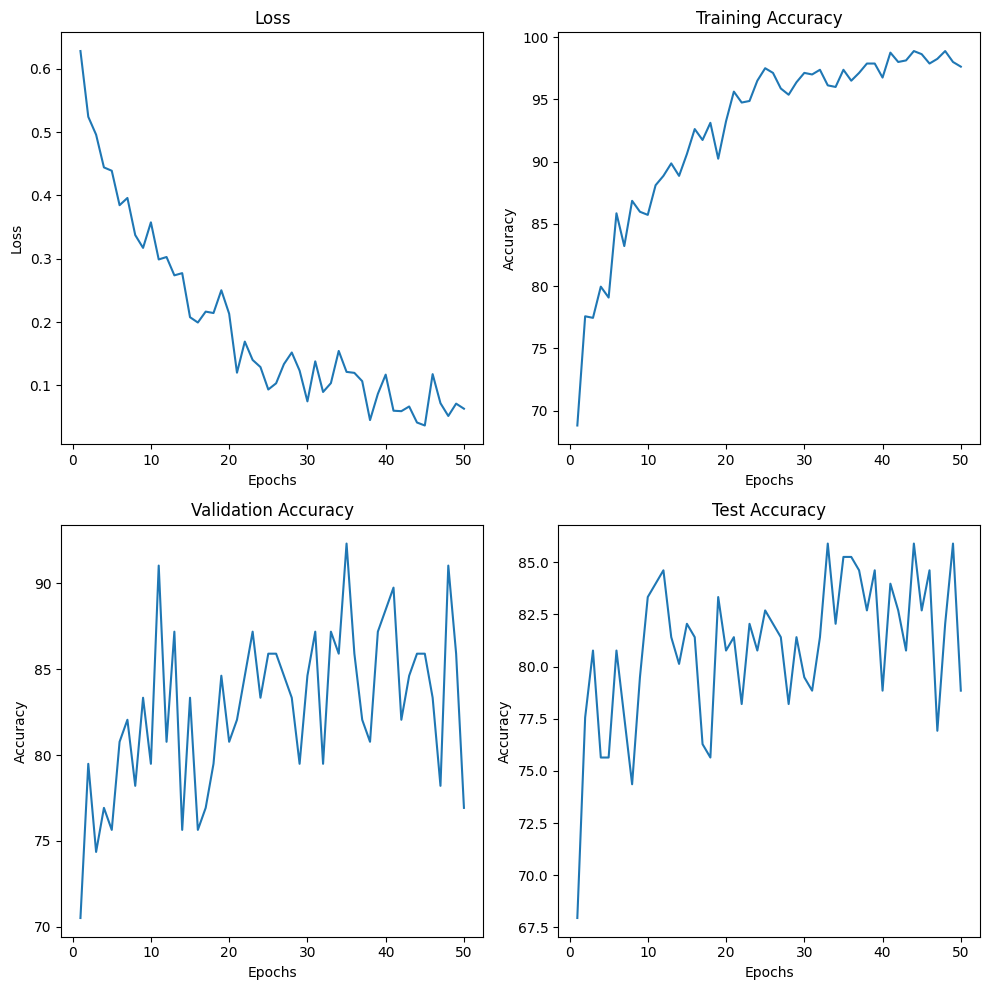

In [241]:
# Plotting Loss
epochs = range(1, NUM_EPOCHS+1)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot Loss
axs[0, 0].plot(epochs, total_loss)
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('Loss')

# Plot Train Accuracy
axs[0, 1].plot(epochs, train_accuracy)
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_title('Training Accuracy')

# Plot Validation Accuracy
axs[1, 0].plot(epochs, val_accuracy)
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('Validation Accuracy')

# Plot Test Accuracy
axs[1, 1].plot(epochs, test_accuracy)
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

In [242]:
# Calculate test accuracy and confusion matrix
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.view(-1).to(device)

        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

test_accuracy.append(100 * correct / total)

# Calculate confusion matrix
confusion_mat = confusion_matrix(true_labels, predictions)

print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {total_loss[-1]} - Train Accuracy: {train_accuracy[-1]:.2f}% - Val Accuracy: {val_accuracy[-1]:.2f}% - Test Accuracy: {test_accuracy[-1]:.2f}%")
print("Confusion Matrix:")
print(confusion_mat)

Epoch 50/50 - Loss: 0.06320665226550773 - Train Accuracy: 97.62% - Val Accuracy: 76.92% - Test Accuracy: 78.85%
Confusion Matrix:
[[32 10]
 [23 91]]
